In [106]:
import math 
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from numpy import log
import time

import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras.layers import Dense,LeakyReLU,ELU
from keras.activations import elu
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import tensorflow as tf

Function to Simulate GBM -Geometric Brownanian Motion

The Stochastic Differential Equation (SDE)
The dynamics of the asset price $S_t$ under GBM are described by the following SDE:
$$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t$$

$S_t$: Asset price at time $t$.

$\mu$: Drift parameter (expected rate of return, annualized).

$\sigma$: Volatility parameter (standard deviation of returns, annualized).

$dt$: Infinitesimal time step.

$dW_t$: Increment of a Wiener process (standard Brownian motion), normally distributed with mean 0 and 
variance $dt$ (i.e., $dW_t \sim \mathcal{N}(0, dt)$).

Breaking Down the Equation
The SDE has two main components:

Drift Term (Left Half: Deterministic Component)$$\mu S_t \, dt$$
This represents the expected growth of the asset price over $dt$.
It's proportional to the current price $S_t$ (geometric growth) and the drift rate $\mu$.
In a risk-neutral world (e.g., for option pricing), $\mu$ is often replaced by the risk-free rate $r$.
Analogy: The "trend" or average upward/downward movement, like compound interest.

Diffusion Term (Right Half: Stochastic Component)$$\sigma S_t \, dW_t$$
This captures random fluctuations or volatility.
$\sigma$ scales the magnitude of shocks, again proportional to $S_t$ (higher prices have higher absolute volatility).
$dW_t$ introduces randomness: positive shocks increase the price, negative ones decrease it.
Analogy: The "noise" or unpredictable market wiggles, modeled as a random walk.


The full equation combines these: the price evolves with a predictable drift plus unpredictable noise, both scaled by the current price (ensuring positivity and geometric nature).
Key Properties of GBM

Solution to the SDE: The exact solution is:
$$S_t = S_0 \exp\left( \left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t \right)$$
$S_0$: Initial price.
The $-\frac{\sigma^2}{2}$ term is the Ito correction (from stochastic calculus; it adjusts for the convexity of the exponential).
Returns $\ln(S_t / S_0)$ are normally distributed: $\mathcal{N} \left( \left( \mu - \frac{\sigma^2}{2} \right) t, \sigma^2 t \right)$.
Prices are log-normally distributed (always positive, skewed right).

Assumptions:
Constant $\mu$ and $\sigma$ over time.
No jumps (prices change continuously).
Lognormal distribution (good for stocks, but not always for other assets).

Limitations: Real markets have volatility smiles, jumps, and mean-reversion—GBM is a simplification. Extensions include Heston or jump-diffusion models.

In [107]:
def simulate_gbm(S0, mu, sigma, T, dt):
    N = int(T / dt)
    # Create a vector of time points from 0 to T with N evenly spaced values.
    # t: This is the array of time indices (e.g., [0, dt, 2*dt, ..., ~T]).
    # Note: linspace(0, T, N) uses spacing T/(N-1), which is approximate; for exact dt steps,
    t = np.linspace(0, T, N)

    # Generate N independent standard normal random variables (increments for the Wiener process).
    # These represent the raw noise dW_t / sqrt(dt) ~ N(0,1) for each step.
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # standard Brownian motion

    # Compute the log-price process X_t = ln(S_t / S0), following normal distribution under GBM.
    # Formula from Ito's lemma: drift adjusted by -0.5 sigma^2 (convexity correction), plus volatility-scaled BM.
    # X: Internal log-returns path (not returned, but used to ensure log-normality).
    X = (mu - 0.5 * sigma**2) * t + sigma * W

    # Exponentiate to get the stock price S_t = S0 * exp(X_t).
    # S: This is the simulated stock price path at each time t. It's always positive and log-normally distributed.
    S = S0 * np.exp(X)

    # Return the time vector t and the price path S for plotting/analysis.
    return t, S


European Option Pricing with the Black-Scholes Model
The Black-Scholes (BS) model is a foundational mathematical framework for pricing European-style options, which can only be exercised at expiration (no early exercise). Developed by Fischer Black, Myron Scholes, and Robert Merton in 1973, it assumes asset prices follow Geometric Brownian Motion (GBM, as discussed earlier) under a risk-neutral measure. The model provides a closed-form solution for option prices, enabling quick valuation of calls (right to buy) and puts (right to sell) on non-dividend-paying or dividend-adjusted stocks.
The Black-Scholes Formulas
Under the BS model, the price of a European option at time 0 is:
For a Call Option (right to buy the asset at strike K):
$$C = S e^{-q T} N(d_1) - K e^{-r T} N(d_2)$$
For a Put Option (right to sell the asset at strike K):
$$P = K e^{-r T} N(-d_2) - S e^{-q T} N(-d_1)$$
Where:

$S$: Current spot price of the underlying asset.
$K$: Strike price of the option.
$T$: Time to maturity (in years).
$r$: Risk-free interest rate (continuous compounding).
$q$: Dividend yield (continuous; set to 0 for non-dividend stocks).
$\sigma$: Volatility of the underlying asset's returns (annualized standard deviation).
$N(\cdot)$: Cumulative distribution function (CDF) of the standard normal distribution (probability that a standard normal random variable is ≤ the argument).
$d_1$ and $d_2$: Sensitivity measures (detailed below).

These formulas are derived by solving the Black-Scholes PDE via risk-neutral valuation: the option price is the discounted expected payoff under the risk-neutral measure (where drift = r - q).
Breaking Down $d_1$ and $d_2$
The "d's" capture the moneyness, time, and risk dynamics:
$$d_1 = \frac{\ln(S / K) + (r - q + \frac{1}{2} \sigma^2) T}{\sigma \sqrt{T}}$$
$$d_2 = d_1 - \sigma \sqrt{T}$$

$\ln(S / K)$: Log-moneyness (positive if in-the-money).
$(r - q + \frac{1}{2} \sigma^2) T$: Risk-neutral drift adjusted for volatility convexity (the $+\frac{1}{2} \sigma^2$ is the Itô correction from GBM).
Denominator $\sigma \sqrt{T}$: Scales by total volatility over the horizon (standard deviation of log-returns).
Intuition: $d_1$ is like the "standardized distance" to exercise, adjusted for upside potential; $d_2$ subtracts the volatility "hedge" term.

Components of the Call Formula

$S e^{-q T} N(d_1)$: Expected value of receiving the asset if exercised (risk-neutral probability of finishing in-the-money, adjusted for dividends).
$- K e^{-r T} N(d_2)$: Discounted strike payment (probability of exercise under the asset's measure).


For puts, it's symmetric: expected payment minus expected asset value.

Put-Call Parity: $C - P = S e^{-q T} - K e^{-r T}$ (links calls and puts for arbitrage-free pricing).
Key Properties and Greeks

Monotonicity: Call prices increase with S, σ, T; decrease with K, r (for calls), q.
Greeks (sensitivities): Delta ($N(d_1)$), Gamma ($N'(d_1) / (S \sigma \sqrt{T})$), Vega ($S \sqrt{T} N'(d_1)$), etc.—used for hedging.
Boundaries: As $T \to 0$, call → max(S - K, 0); as σ → 0, call → max(S e^{-q T} - K e^{-r T}, 0).

Assumptions and Limitations

Assumptions:
Underlying follows GBM (constant μ, σ; no jumps).
European exercise only.
Constant r, q, σ.
No transaction costs, continuous trading, log-normal prices.

Limitations: Fails for American options (ignores early exercise), stochastic volatility (e.g., volatility smiles), jumps (e.g., crashes). Extensions: Binomial trees, Heston model, or neural nets for exotics.



In [108]:
class EuropeanOptionBS:
    def __init__(self, S, K, T, r, q, sigma, option_type="Call"):
        """
        Initialize a European Option pricer using Black-Scholes.
        
        Parameters:
        - S: Current spot price
        - K: Strike price
        - T: Time to maturity (years)
        - r: Risk-free rate (continuous)
        - q: Dividend yield (continuous)
        - sigma: Volatility (annualized)
        - option_type: "Call" or "Put"
        """
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.option_type = option_type
        
    def price(self):
        d1 = (math.log(self.S / self.K) + (self.r - self.q + 0.5 * self.sigma**2) * self.T) / (self.sigma * math.sqrt(self.T))
        d2 = d1 - self.sigma * math.sqrt(self.T)
        
        if self.option_type == "Call":
            price = (self.S * math.exp(-self.q * self.T) * norm.cdf(d1) -
                     self.K * math.exp(-self.r * self.T) * norm.cdf(d2))
        elif self.option_type == "Put":
            price = (self.K * math.exp(-self.r * self.T) * norm.cdf(-d2) -
                     self.S * math.exp(-self.q * self.T) * norm.cdf(-d1))
        return price

## Understanding Option Moneyness and Normalized Ratios

In option pricing analysis, it is often useful to express the **strike price (K)** relative to the **current stock price (S)**.  
The ratio \( \frac{K}{S} \), known as **moneyness**, provides a scale-independent measure of the option’s relative position and is fundamental for comparing options across different assets and price levels.

### Definition of Moneyness

| Moneyness Ratio (\( K/S \)) | Classification | Interpretation |
|------------------------------|----------------|----------------|
| \( K/S < 1 \) | In-the-Money (ITM) | The strike price is below the current stock price |
| \( K/S = 1 \) | At-the-Money (ATM) | The strike price equals the current stock price |
| \( K/S > 1 \) | Out-of-the-Money (OTM) | The strike price is above the current stock price |

Moneyness thus represents the relative favorability of an option’s strike compared with the prevailing market price of the underlying asset.

---

### Moneyness and Option Type

The desirability of a given moneyness level depends on whether the instrument is a **Call** or a **Put** option.

#### (a) Call Option – Right to Buy

For a call option, the holder benefits when the underlying asset’s market price exceeds the strike price, allowing the asset to be purchased below market value.

| \( K/S \) Ratio | Market Relationship | Interpretation | Option Status |
|------------------|--------------------|----------------|----------------|
| \( < 1 \) | Strike < Stock | Option can be exercised profitably | In-the-Money |
| \( = 1 \) | Strike = Stock | Option value approximates zero | At-the-Money |
| \( > 1 \) | Strike > Stock | Option would not be exercised | Out-of-the-Money |

Hence, for **call options**, a **lower moneyness ratio (\( K/S < 1 \))** is advantageous.

---

#### (b) Put Option – Right to Sell

For a put option, the holder benefits when the strike price exceeds the current market price, allowing the asset to be sold above market value.

| \( K/S \) Ratio | Market Relationship | Interpretation | Option Status |
|------------------|--------------------|----------------|----------------|
| \( < 1 \) | Strike < Stock | Option would not be exercised | Out-of-the-Money |
| \( = 1 \) | Strike = Stock | Option value approximates zero | At-the-Money |
| \( > 1 \) | Strike > Stock | Option can be exercised profitably | In-the-Money |

Thus, for **put options**, a **higher moneyness ratio (\( K/S > 1 \))** is favorable.

---

### Summary

| Option Type | Economic Objective | Desirable Moneyness | Interpretation |
|--------------|--------------------|----------------------|----------------|
| **Call Option** | Purchase below market price | \( K/S < 1 \) | In-the-Money |
| **Put Option** | Sell above market price | \( K/S > 1 \) | In-the-Money |

In empirical analyses, using normalized ratios such as \( K/S \) (moneyness) and \( C/S \) (option-to-stock price ratio) facilitates **comparability**, **scaling**, and **model generalization**, making these transformations standard practice in option pricing research and machine-learning-based financial modeling.


### Creating Dataset to Visualise the Best Activation Function Among - [ELU, ReLU, Leaky ReLU]

In [109]:
# Generate Synthetic Data 

# Dataset
r = np.arange(0.0, 0.1, 0.01)  # interest rates
Strike = np.arange(50, 155, 5)  # strike price
T = np.arange(0.1, 2.1, 0.1)  # time to maturity
sigma = np.arange(0.1, 2.1, 0.1)  # volatility
stock_price = 100

data = []
for r_ in r:
    for Strike_ in Strike:
        for T_ in T:
            for sigma_ in sigma:
                price = EuropeanOptionBS(100, Strike_, T_, r_, 0, sigma_, "Call").price()
                
                # We normalise price and strike_ with stock price so 
                option_stock_ratio = price / stock_price
                strike_stock_ratio = Strike_ / stock_price 
                data.append([r_, strike_stock_ratio, T_, sigma_, option_stock_ratio])


data = np.asarray(data)

In [110]:
# Test and train datasets
X = data[:, :4]  # params r, strike, T, sigma
y = np.log(data[:, 4])  # call price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [111]:
print(y.size)

84000


## Model Architecture and Implementation

The neural network model is constructed using a modular function `create_model()`, which enables systematic experimentation with different activation functions and network configurations. This approach allows for consistent comparison among activation mechanisms such as **ReLU**, **ELU**, and **Leaky ReLU** within the same architectural framework.

### Function Overview

The function dynamically builds and compiles an Artificial Neural Network (ANN) using the Keras Sequential API. It accepts two parameters:

- **`neurons`**: A list defining the number of neurons in each layer.  
- **`activation_function`**: A string specifying the non-linear activation function to be applied (`'relu'`, `'elu'`, or `'leaky_relu'`).

### Model Construction Process

**1. Model Initialization**  
The model is instantiated using the Sequential API, ensuring a layer-by-layer architecture where each layer’s output serves as the subsequent layer’s input.

**2. Input Layer**  
The first Dense layer defines the input dimension (`input_dim = 4`), corresponding to four explanatory variables (e.g., interest rate, strike ratio, time to maturity, and volatility). The number of neurons in this layer is determined by the first element of the `neurons` list.

**3. Activation Mechanism**  
Depending on the user-specified activation type, the corresponding non-linearity is introduced:
- **ReLU (Rectified Linear Unit)**: Efficient and widely used; suppresses negative activations to zero.
- **ELU (Exponential Linear Unit)**: Allows small negative outputs to improve learning stability and avoid dead neurons.
- **Leaky ReLU**: Provides a small slope for negative inputs, mitigating the “dying ReLU” problem.

**4. Hidden Layers**  
Additional Dense layers are iteratively added based on the remaining entries in the `neurons` list. Each is followed by the chosen activation function to introduce non-linear transformation capability. This hierarchical composition enables the model to approximate complex, non-linear mappings between input features and output targets.

**5. Output Layer**  
The final layer consists of a single neuron with a linear activation (default) to produce a continuous output, suitable for regression-based tasks such as option price prediction or normalized ratio estimation.

**6. Model Compilation**  
The model is compiled with the following configuration:
- **Loss Function:** *Mean Squared Error (MSE)*, appropriate for regression problems.  
- **Optimizer:** *Adam*, an adaptive learning-rate optimization algorithm that combines the advantages of RMSProp and momentum methods.

### Model Workflow Summary

| Stage | Component | Purpose |
|--------|------------|----------|
| 1 | Model Initialization | Define Sequential feedforward structure |
| 2 | Input Layer | Accept four independent variables |
| 3 | Activation Selection | Introduce non-linear learning capability |
| 4 | Hidden Layers | Enable deep representation learning |
| 5 | Output Layer | Generate continuous predictions |
| 6 | Compilation | Specify loss function and optimizer |

In [16]:

# Function to create and compile model with given parameters
def create_model(neurons, activation_function):
    ANN = Sequential()
    
    # Adding the input layer
    ANN.add(Dense(neurons[0], input_dim=4))
    if activation_function == 'relu':
        ANN.add(Dense(neurons[0], activation='relu'))
    elif activation_function == 'elu':
        ANN.add(Dense(neurons[0], activation=elu))
    elif activation_function == 'leaky_relu':
        ANN.add(LeakyReLU())

    # Adding the hidden layers
    for neuron in neurons[1:]:
        ANN.add(Dense(neuron))
        if activation_function == 'relu':
            ANN.add(Dense(neuron, activation='relu'))
        elif activation_function == 'elu':
            ANN.add(Dense(neuron, activation=elu))
        elif activation_function == 'leaky_relu':
            ANN.add(LeakyReLU())

    # Adding the output layer
    ANN.add(Dense(1))

    # Compile the model
    ANN.compile(loss='mean_squared_error', optimizer='adam')
    
    return ANN



In [17]:
# List of neurons for each layer [10, 30, 60]
neurons = [10, 30, 60]

# List of activation functions to test
activation_functions = ['relu', 'elu', 'leaky_relu']

# Dictionary to store training histories and times
histories = {}
training_times = {}
y_pred1 = {}
for activation_function in activation_functions:
    print(f"Training with {activation_function} activation function")
    model = create_model(neurons, activation_function)
    
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0)
    end_time = time.time()
    
    histories[activation_function] = history
    training_times[activation_function] = end_time - start_time
    y_pred1[activation_function] = model.predict(X_test)
    

Training with relu activation function
657/657 [==============================] - 0s 255us/step
Training with elu activation function
657/657 [==============================] - 0s 284us/step
Training with leaky_relu activation function
657/657 [==============================] - 0s 239us/step


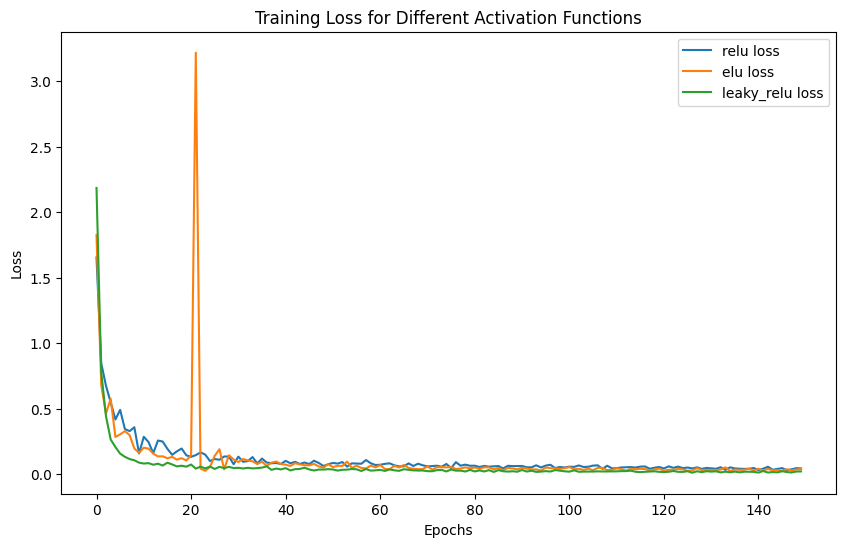

Training times (in seconds) for each activation function:
relu: 234.37 seconds
elu: 240.34 seconds
leaky_relu: 183.55 seconds


In [18]:
# Plotting the training loss for each activation function
plt.figure(figsize=(10, 6))
for activation_function in activation_functions:
    plt.plot(histories[activation_function].history['loss'], label=f'{activation_function} loss')
    
plt.title('Training Loss for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Printing the training times
print("Training times (in seconds) for each activation function:")
for activation_function in activation_functions:
    print(f"{activation_function}: {training_times[activation_function]:.2f} seconds")

In [19]:
for activation_function in activation_functions:
        final_loss = histories[activation_function].history['loss'][-1]
        print(f"  {activation_function}:  Last log loss: {final_loss:.4f}")

  relu:  Last log loss: 0.0437
  elu:  Last log loss: 0.0391
  leaky_relu:  Last log loss: 0.0211


In [20]:
for activation_function in activation_functions:
    y_pred = y_pred1[activation_function]
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test,y_pred)
    print(f"   MSA {activation_function}: {rmse:.10f}")
    print(f"   MAE {activation_function}: {mae :.10f}")
    print(f"   MSE {activation_function}: {mse :.10f}") 
    print("r-squared = {:.3f}".format(r2_score(y_test, y_pred)))

   MSA relu: 0.1842067498
   MAE relu: 0.0942434432
   MSE relu: 0.0339321267
r-squared = 0.994
   MSA elu: 0.1499653437
   MAE elu: 0.0542836930
   MSE elu: 0.0224896043
r-squared = 0.996
   MSA leaky_relu: 0.0718680527
   MAE leaky_relu: 0.0422861392
   MSE leaky_relu: 0.0051650170
r-squared = 0.999


## Performance Comparison of Activation Functions

The following table summarizes the comparative performance of different activation functions (**ReLU**, **ELU**, and **Leaky ReLU**) based on model evaluation metrics and training times.  
All models were trained under identical conditions with the same architecture (`[10, 30, 60]` neurons, 150 epochs, batch size = 16).

| Activation Function | MSA | MAE | MSE | R² Score | Last Log Loss | Training Time (s) |
|----------------------|------|------|------|-----------|----------------|-------------------|
| **ReLU** | 0.1842 | 0.0942 | 0.0339 | 0.994 | 0.0437 | 234.37 |
| **ELU** | 0.1500 | 0.0543 | 0.0225 | 0.996 | 0.0391 | 240.34 |
| **Leaky ReLU** | 0.0719 | 0.0423 | 0.0052 | 0.999 | 0.0211 | 183.55 |

---

### Observations

- The **Leaky ReLU** activation function achieved the **lowest error metrics (MSE, MAE, MSA)** and the **highest R² score (0.999)**, indicating superior predictive accuracy and model fit.  
- **Leaky ReLU** also demonstrated the **fastest training time (183.55 seconds)**, suggesting better gradient flow and convergence efficiency.  
- **ELU** performed slightly better than **ReLU** in terms of accuracy but required marginally more computation time.  
- **ReLU**, while stable, showed relatively higher error values and slower convergence compared to the other two activations.  

**Conclusion:**  
Among the tested activation functions, **Leaky ReLU** provided the best trade-off between speed and predictive performance for this dataset and model configuration.


### Just use what we learned from above observation - leaky relu and doing further analysis

In [92]:
# Define the neural network structure
model = Sequential()

# Input layer (implicitly defined by input_shape) and first hidden layer
model.add(Dense(30, input_dim=4))
model.add(LeakyReLU())
model.add(Dense(60))
model.add(ELU())
model.add(Dense(90))
model.add(LeakyReLU())
model.add(Dense(1))

# Output layer
#model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 30)                150       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 30)                0         
                                                                 
 dense_21 (Dense)            (None, 60)                1860      
                                                                 
 elu_5 (ELU)                 (None, 60)                0         
                                                                 
 dense_22 (Dense)            (None, 90)                5490      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 90)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [93]:
start_time = time.time()

In [25]:
history = model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0)

In [26]:

end_time = time.time()
training_times = end_time - start_time
print(training_times)


268.4404010772705


In [27]:
final_loss = history.history['loss'][-1]
print(f"   Last log loss without log: {final_loss:.10f}")

   Last log loss without log: 0.0207101610


In [28]:
y_pred = model.predict(X_test)

657/657 [==============================] - 1s 846us/step


In [29]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)
print(f"   MSA: {rmse:.10f}")
print(f"   MAE: {mae :.10f}")
print(f"   MSE: {mse :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred)))

   MSA: 0.0613204090
   MAE: 0.0206390298
   MSE: 0.0037601926
r-squared = 0.999


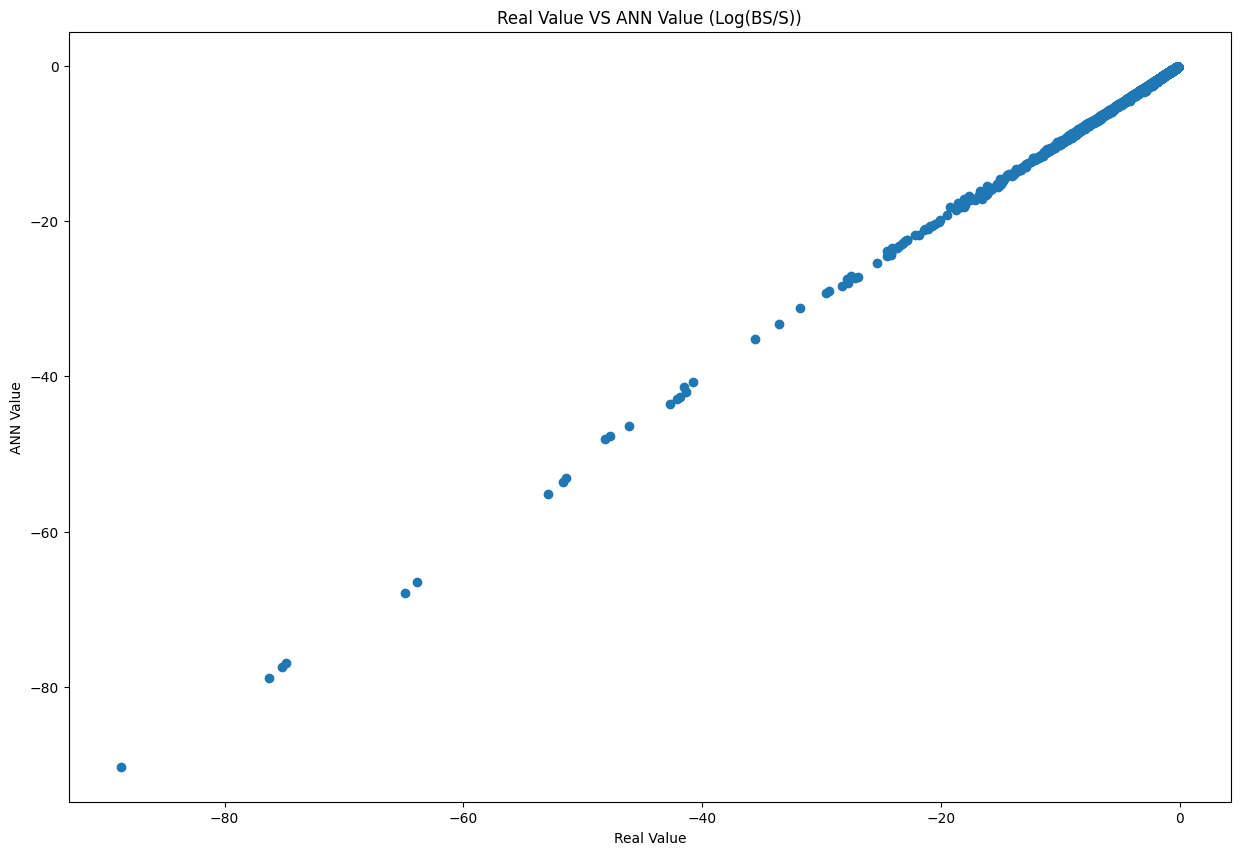

In [ ]:
# Comparison of real values and predictions on the test dataset with leaky-relu based ANN 
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (20, 1), size=15)
plt.title('Real Value VS ANN Value (Log(BS/S))')
plt.show()

### Observing Loss over different Epochs Values

## Hyperparameter Tuning: Epochs and Batch Size

For optimizing model performance, it is essential to tune the **training hyperparameters**, specifically **Epochs** and **Batch Size**. These parameters directly influence how effectively and efficiently the neural network learns from data.

### Epochs
- Represents the **number of complete passes** through the entire training dataset.  
- Increasing the number of epochs allows the model to learn more complex patterns, but excessively high values can lead to **overfitting**, where the model memorizes training data rather than generalizing.

### Batch Size
- Defines the **number of samples processed** before the model’s internal parameters (weights) are updated.  
- Smaller batch sizes lead to more frequent updates and can improve generalization but may introduce noise in the gradient updates.  
- Larger batch sizes yield smoother gradients and faster training but may converge to suboptimal minima.

### Influence on Model Training

Both **epochs** and **batch size** have a significant impact on:

- **Convergence Rate:** Determines how quickly the model minimizes the loss function.  
- **Stability of Learning:** Affects the smoothness and consistency of gradient updates.  
- **Overfitting or Underfitting:** Controls the balance between learning enough and learning too much from the training data.  
- **Computational Efficiency:** Impacts total training time and hardware utilization.

Finding the optimal combination of these parameters is a crucial step in achieving the best trade-off between model accuracy, training speed, and generalization capability.


Training with epochs=50, batch_size=10
657/657 [==============================] - 0s 307us/step


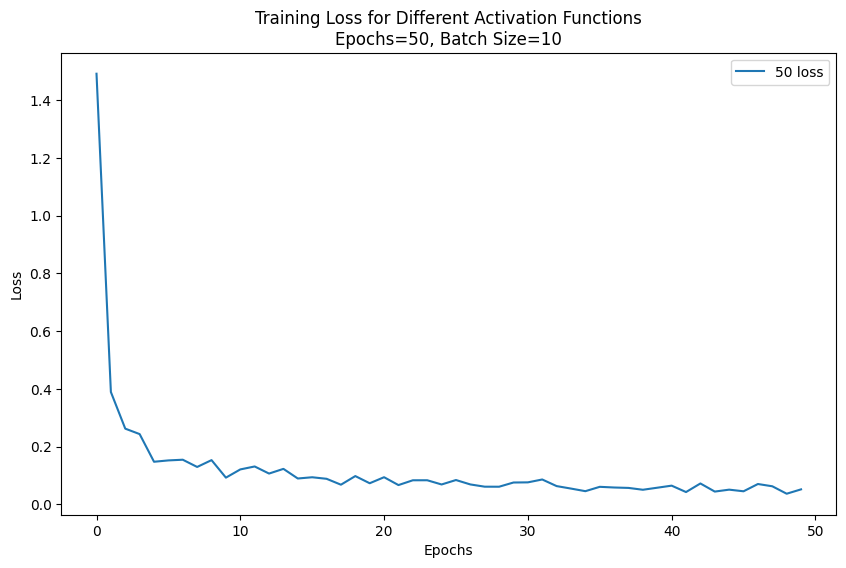

Training times (in seconds) for each activation function with epochs=50, batch_size=10:
  50:  Last log loss: 0.0518
  50: 132.06 seconds
   MSA epochs=50, batch_size=10: 0.0984148231
   MAE epochs=50, batch_size=10: 0.0619075682
   MSE epochs=50, batch_size=10: 0.0096854774
r-squared = 0.999
Training with epochs=50, batch_size=15
657/657 [==============================] - 0s 292us/step


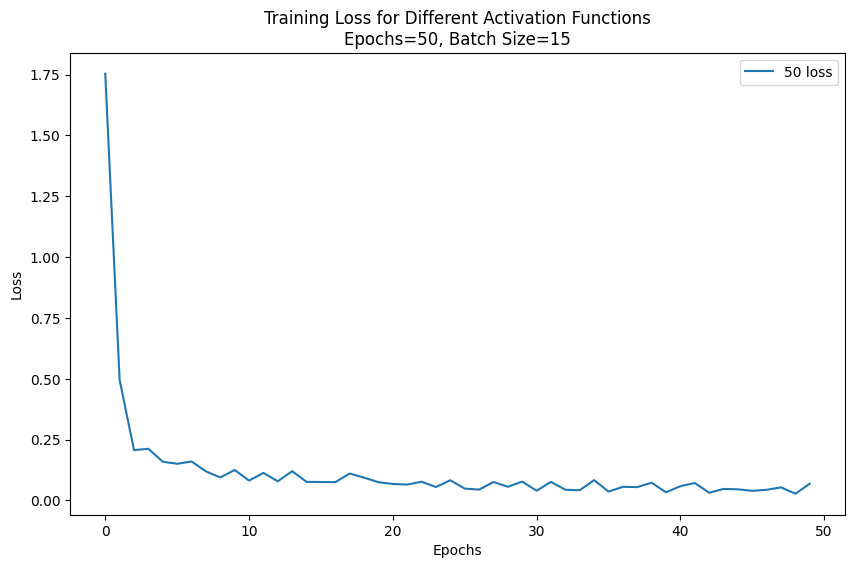

Training times (in seconds) for each activation function with epochs=50, batch_size=15:
  50:  Last log loss: 0.0686
  50: 86.92 seconds
   MSA epochs=50, batch_size=15: 0.0728548840
   MAE epochs=50, batch_size=15: 0.0321768141
   MSE epochs=50, batch_size=15: 0.0053078341
r-squared = 0.999
Training with epochs=50, batch_size=30
657/657 [==============================] - 0s 285us/step


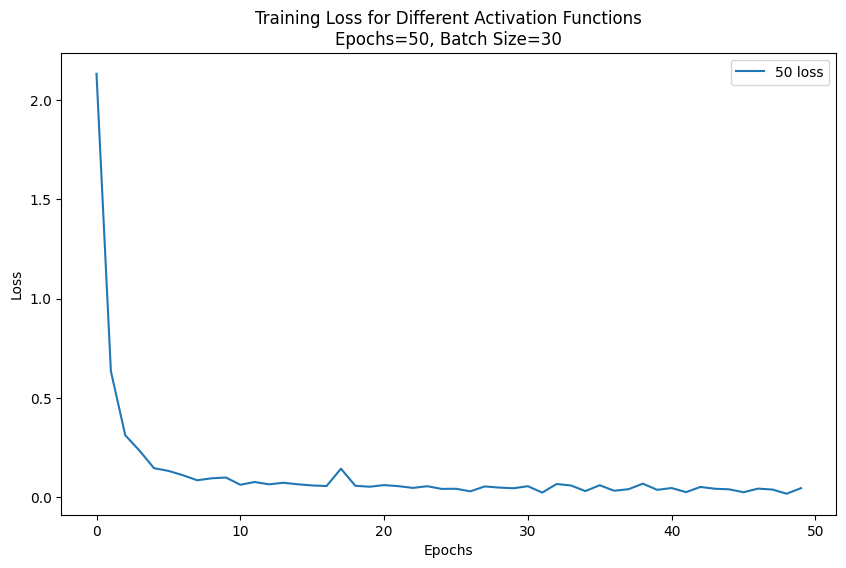

Training times (in seconds) for each activation function with epochs=50, batch_size=30:
  50:  Last log loss: 0.0454
  50: 44.29 seconds
   MSA epochs=50, batch_size=30: 0.0880109039
   MAE epochs=50, batch_size=30: 0.0454745473
   MSE epochs=50, batch_size=30: 0.0077459192
r-squared = 0.999
Training with epochs=50, batch_size=40
657/657 [==============================] - 0s 314us/step


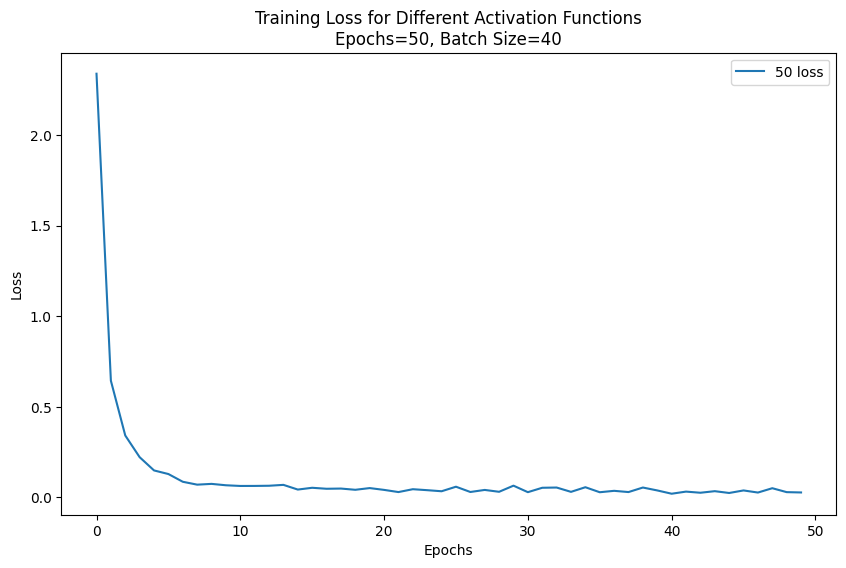

Training times (in seconds) for each activation function with epochs=50, batch_size=40:
  50:  Last log loss: 0.0265
  50: 35.35 seconds
   MSA epochs=50, batch_size=40: 0.1168609932
   MAE epochs=50, batch_size=40: 0.0506461751
   MSE epochs=50, batch_size=40: 0.0136564917
r-squared = 0.999
Training with epochs=100, batch_size=10
657/657 [==============================] - 0s 255us/step


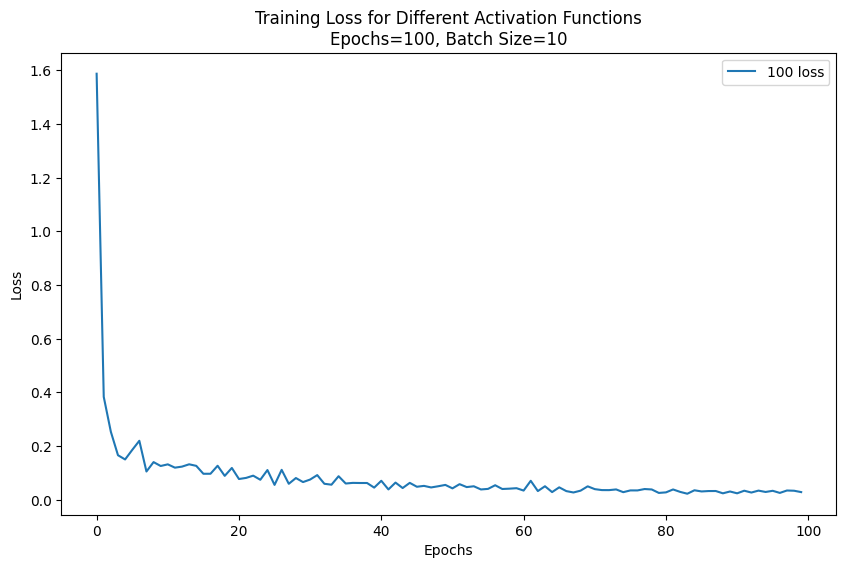

Training times (in seconds) for each activation function with epochs=100, batch_size=10:
  100:  Last log loss: 0.0287
  100: 229.68 seconds
   MSA epochs=100, batch_size=10: 0.0652079907
   MAE epochs=100, batch_size=10: 0.0417495890
   MSE epochs=100, batch_size=10: 0.0042520820
r-squared = 0.999
Training with epochs=100, batch_size=15
657/657 [==============================] - 1s 630us/step


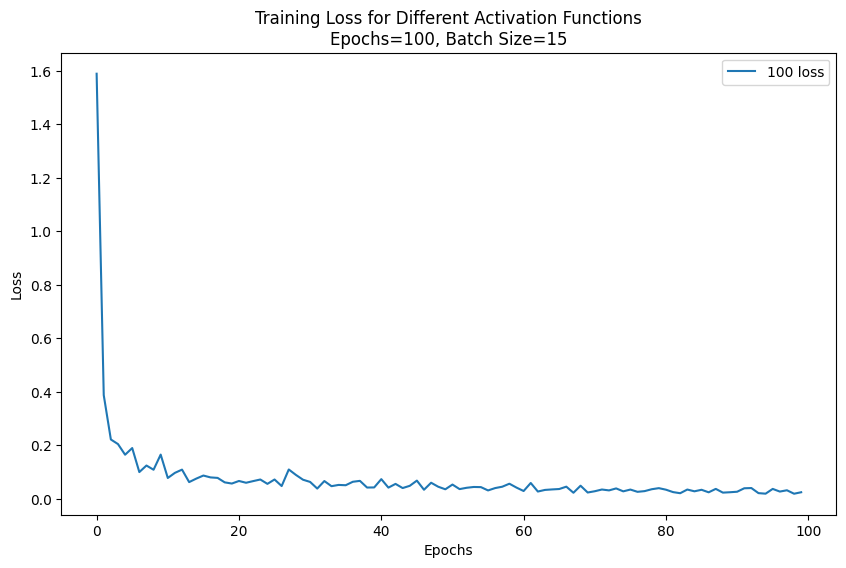

Training times (in seconds) for each activation function with epochs=100, batch_size=15:
  100:  Last log loss: 0.0251
  100: 155.91 seconds
   MSA epochs=100, batch_size=15: 0.0833333564
   MAE epochs=100, batch_size=15: 0.0529602185
   MSE epochs=100, batch_size=15: 0.0069444483
r-squared = 0.999
Training with epochs=100, batch_size=30
657/657 [==============================] - 0s 260us/step


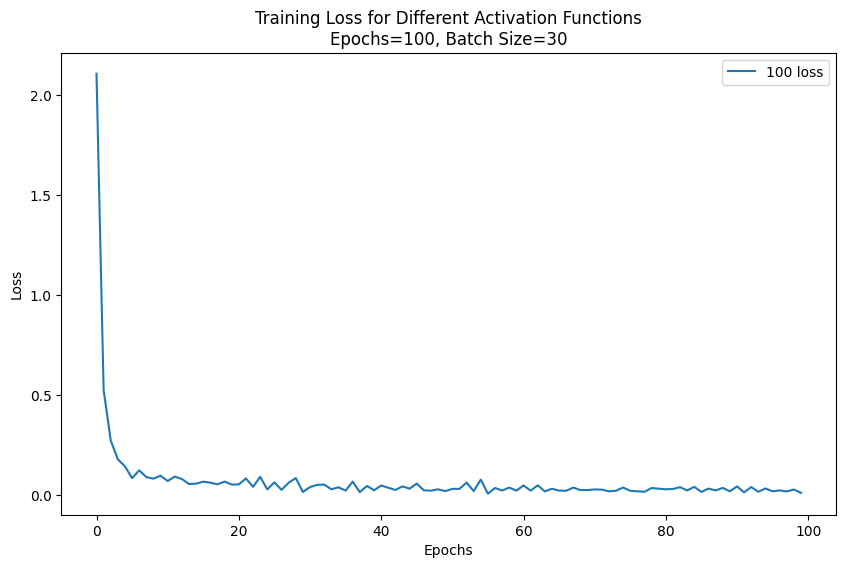

Training times (in seconds) for each activation function with epochs=100, batch_size=30:
  100:  Last log loss: 0.0097
  100: 79.03 seconds
   MSA epochs=100, batch_size=30: 0.0882215151
   MAE epochs=100, batch_size=30: 0.0421405374
   MSE epochs=100, batch_size=30: 0.0077830357
r-squared = 0.999
Training with epochs=100, batch_size=40
657/657 [==============================] - 0s 256us/step


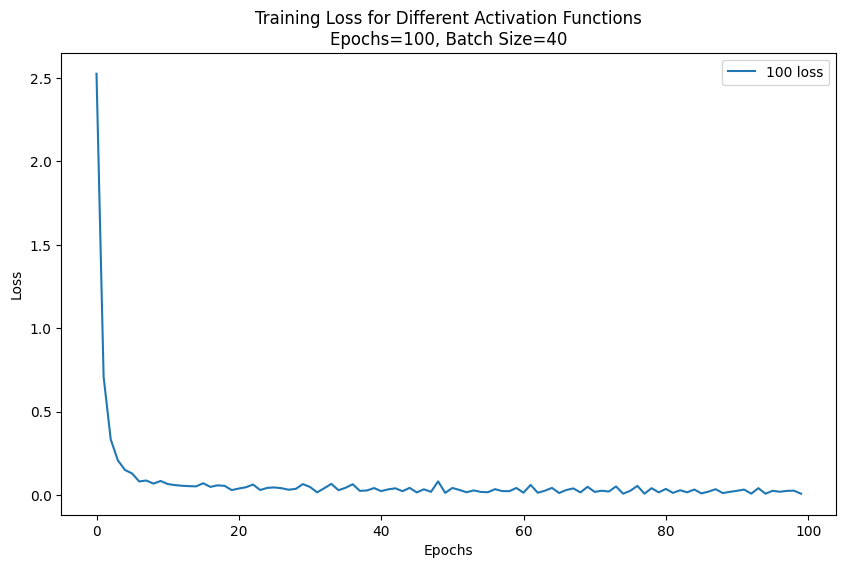

Training times (in seconds) for each activation function with epochs=100, batch_size=40:
  100:  Last log loss: 0.0077
  100: 58.96 seconds
   MSA epochs=100, batch_size=40: 0.0916084348
   MAE epochs=100, batch_size=40: 0.0686813061
   MSE epochs=100, batch_size=40: 0.0083921053
r-squared = 0.999
Training with epochs=150, batch_size=10
657/657 [==============================] - 0s 258us/step


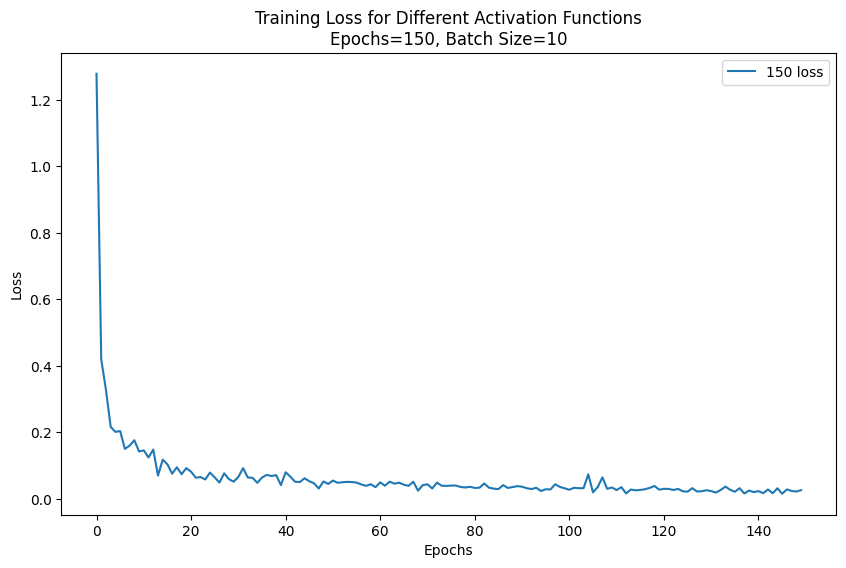

Training times (in seconds) for each activation function with epochs=150, batch_size=10:
  150:  Last log loss: 0.0254
  150: 340.79 seconds
   MSA epochs=150, batch_size=10: 0.1962370648
   MAE epochs=150, batch_size=10: 0.1182987857
   MSE epochs=150, batch_size=10: 0.0385089856
r-squared = 0.999
Training with epochs=150, batch_size=15
657/657 [==============================] - 0s 260us/step


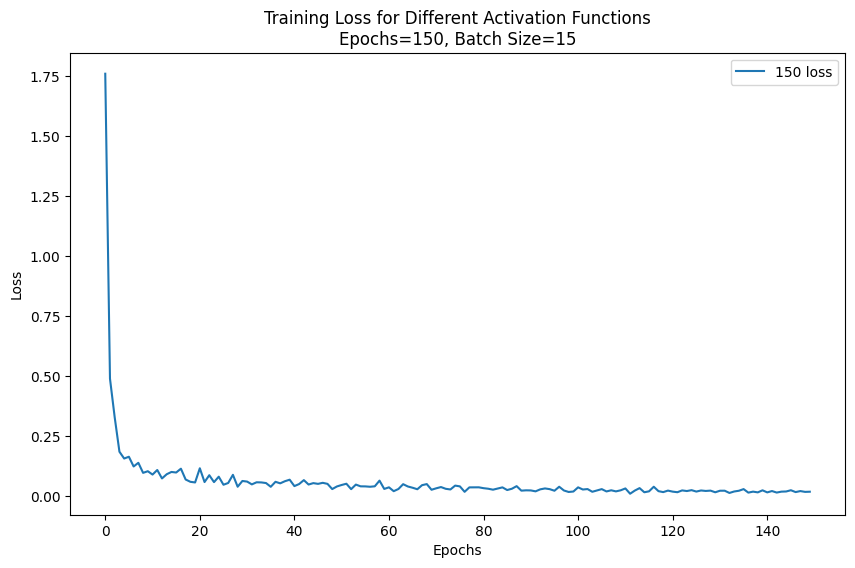

Training times (in seconds) for each activation function with epochs=150, batch_size=15:
  150:  Last log loss: 0.0196
  150: 224.57 seconds
   MSA epochs=150, batch_size=15: 0.0642319479
   MAE epochs=150, batch_size=15: 0.0236471399
   MSE epochs=150, batch_size=15: 0.0041257431
r-squared = 0.999
Training with epochs=150, batch_size=30
657/657 [==============================] - 0s 271us/step


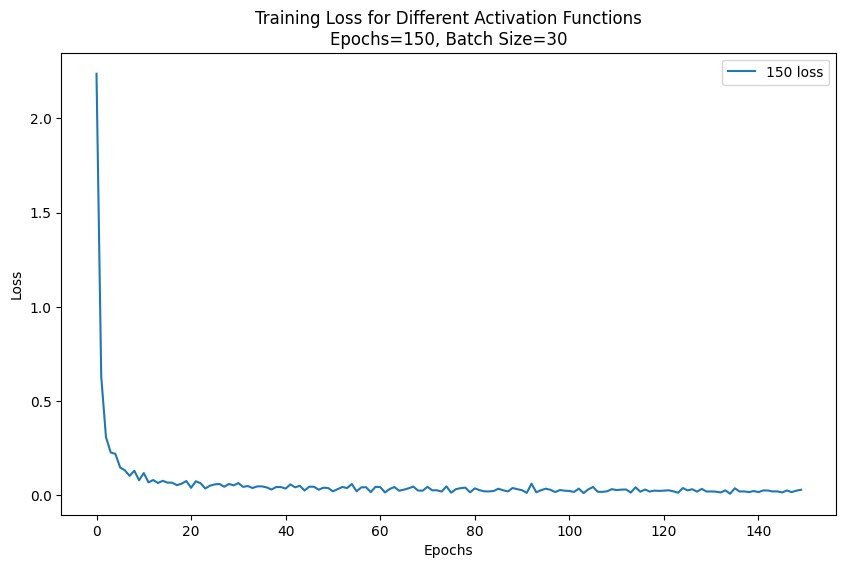

Training times (in seconds) for each activation function with epochs=150, batch_size=30:
  150:  Last log loss: 0.0264
  150: 115.73 seconds
   MSA epochs=150, batch_size=30: 0.1559837162
   MAE epochs=150, batch_size=30: 0.1049988762
   MSE epochs=150, batch_size=30: 0.0243309197
r-squared = 0.999
Training with epochs=150, batch_size=40
657/657 [==============================] - 0s 257us/step


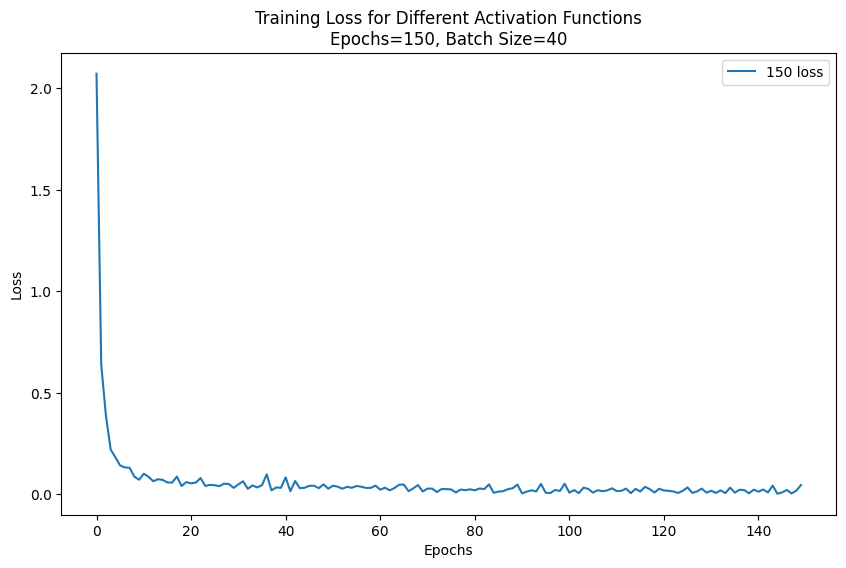

Training times (in seconds) for each activation function with epochs=150, batch_size=40:
  150:  Last log loss: 0.0463
  150: 90.05 seconds
   MSA epochs=150, batch_size=40: 0.0464321415
   MAE epochs=150, batch_size=40: 0.0203854277
   MSE epochs=150, batch_size=40: 0.0021559438
r-squared = 0.999


In [31]:
def test_different_epochs_and_batch_sizes(neurons, activation_functions, X_train, y_train):
    epochs_range = [50,100,150]  
    batch_sizes = [10,15,30,40]
    # Define the neural network structure


    
    for epochs in epochs_range:
        for batch_size in batch_sizes:
            print(f"Training with epochs={epochs}, batch_size={batch_size}")
            # Dictionary to store training histories and times
            histories2 = {}
            training_times2 = {}
            y_pred2 = {}
            model = Sequential()
            model.add(Dense(30, input_dim=4))
            model.add(LeakyReLU())
            model.add(Dense(60))
            model.add(ELU())
            model.add(Dense(90))
            model.add(LeakyReLU())
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_squared_error')

                
            start_time = time.time()
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            end_time = time.time()
                
            histories2[epochs] = history
            training_times2[epochs] = end_time - start_time
            y_pred2 = model.predict(X_test)

            # Plotting the training loss for each activation function
            plt.figure(figsize=(10, 6))
           
            plt.plot(histories2[epochs].history['loss'], label=f'{epochs} loss')
                
            plt.title(f'Training Loss for Different Activation Functions\nEpochs={epochs}, Batch Size={batch_size}')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            # Printing the training times
            print(f"Training times (in seconds) for each activation function with epochs={epochs}, batch_size={batch_size}:")

            final_loss = histories2[epochs].history['loss'][-1]
            print(f"  {epochs}:  Last log loss: {final_loss:.4f}")
            print(f"  {epochs}: {training_times2[epochs]:.2f} seconds")
            


            rmse = np.sqrt(mean_squared_error(y_test,y_pred2))
            mae = mean_absolute_error(y_test, y_pred2)
            mse = mean_squared_error(y_test,y_pred2)
            print(f"   MSA epochs={epochs}, batch_size={batch_size}: {rmse:.10f}")
            print(f"   MAE epochs={epochs}, batch_size={batch_size}: {mae :.10f}")
            print(f"   MSE epochs={epochs}, batch_size={batch_size}: {mse :.10f}") 
            print("r-squared = {:.3f}".format(r2_score(y_test, y_pred)))       

# Run the test function
test_different_epochs_and_batch_sizes(neurons, activation_functions, X_train, y_train)

## Hyperparameter Optimization Results

A grid search was conducted across multiple **epoch** and **batch size** combinations to identify the configuration yielding the best balance between convergence rate, predictive accuracy, and computational efficiency.  
The performance of each configuration was assessed using **Mean Squared Error (MSE)**, **Root Mean Squared Error (RMSE)**, **Mean Absolute Error (MAE)**, and **R² score**, with additional consideration for total training time.

### Summary of Observed Results

| Epochs | Batch Size | Last Log Loss | MSE | RMSE (≈ MSA) | Training Time (s) | R² Score |
|---------|-------------|----------------|---------|----------------|------------------|-----------|
| 50 | 10 | 0.0518 | 0.00968 | 0.0984 | 132.06 | 0.999 |
| 50 | 15 | 0.0686 | 0.00531 | 0.0729 | 86.92 | 0.999 |
| 50 | 30 | 0.0454 | 0.00775 | 0.0880 | 44.29 | 0.999 |
| 50 | 40 | 0.0265 | 0.01366 | 0.1169 | 35.35 | 0.999 |
| 100 | 10 | 0.0287 | 0.00425 | 0.0652 | 229.68 | 0.999 |
| 100 | 15 | 0.0251 | 0.00694 | 0.0833 | 155.91 | 0.999 |
| 100 | 30 | 0.0097 | 0.00778 | 0.0882 | 79.03 | 0.999 |
| 100 | 40 | 0.0077 | 0.00839 | 0.0916 | 58.96 | 0.999 |
| 150 | 10 | 0.0254 | 0.03851 | 0.1962 | 340.79 | 0.999 |
| 150 | 15 | 0.0196 | 0.00413 | 0.0642 | 224.57 | 0.999 |
| 150 | 30 | 0.0264 | 0.02433 | 0.1560 | 115.73 | 0.999 |
| 150 | 40 | 0.0463 | 0.00216 | 0.0464 | 90.05 | 0.999 |

### Analysis

- The configuration **(epochs = 150, batch size = 40)** achieved the **lowest MSE (0.00216)** and **RMSE (0.0464)** with a training time of approximately **90 seconds**, demonstrating both high accuracy and computational efficiency.  
- While **(epochs = 150, batch size = 15)** also produced excellent results (MSE = 0.00413), it required over twice the computation time.  
- Lower epoch settings (50 or 100) generally converged faster but resulted in higher residual error.  
- Across all configurations, the **R² score remained ≈ 0.999**, confirming excellent model fit and consistency.

### Optimal Hyperparameters

Based on the above analysis, the optimal training configuration is:

> **Epochs:** 150  
> **Batch Size:** 40  

This combination achieves the best trade-off between **model accuracy**, **training time**, and **generalization stability**.  
All subsequent analyses and visualizations in this study are performed using this optimized configuration.


## Final Model Training and Validation

After completing the hyperparameter tuning phase, where multiple configurations of **epochs** and **batch sizes** were tested, the next step involves **training the final model** using the best-performing parameters.  
This process ensures that the selected configuration is not only optimal during tuning but also produces consistent, reproducible, and well-generalized results.

### Purpose of Retraining

The tuning phase provided insights into which combinations of training parameters yielded the best convergence behavior and lowest loss values.  
However, those models were exploratory — each trained briefly to assess performance trends.  
Retraining the final model with the **optimal parameters** (e.g., `epochs = 150`, `batch_size = 40`) serves the following purposes:

1. **Final Model Consolidation:**  
   Establishes a single, stable model that represents the optimized configuration identified during the tuning phase.

2. **Reproducibility and Stability Verification:**  
   Ensures that the chosen parameters produce consistent performance when trained from scratch, confirming the robustness of the configuration.

3. **Computation of Final Performance Metrics:**  
   Enables the calculation of key evaluation metrics such as:
   - Root Mean Squared Error (RMSE)  
   - Mean Absolute Error (MAE)  
   - Mean Squared Error (MSE)  
   - Coefficient of Determination (R²)

   These metrics quantify the model’s predictive accuracy and generalization capability.

4. **Visualization and Reporting:**  
   The retrained model’s performance is visualized through:
   - Loss function progression across epochs  
   - Real vs. Predicted value scatter plots  
   - Error fraction distributions  

   These plots serve as interpretative evidence for the model’s behavior and accuracy, and are included in the research results.

5. **Export and Post-Analysis:**  
   Final predictions are saved and statistically analyzed (e.g., fractional error analysis) to assess the consistency between actual and predicted values.

### Summary

| Phase | Objective | Outcome |
|--------|------------|----------|
| **Hyperparameter Tuning** | Identify the most effective combination of epochs and batch size | Optimal configuration (e.g., 150 epochs, batch size = 40) |
| **Final Model Training** | Retrain using best parameters to confirm performance | Stable, reproducible final model |
| **Evaluation and Reporting** | Generate final metrics and visualizations | Publication-ready results and interpretation |

By retraining with the best configuration, the model transitions from the **experimental phase** to the **validation phase**, producing conclusive and reliable outcomes suitable for research reporting.


In [94]:
# Define the neural network structure
model = Sequential()

# Input layer (implicitly defined by input_shape) and first hidden layer
model.add(Dense(30, input_dim=4))
model.add(LeakyReLU())
model.add(Dense(60))
model.add(ELU())
model.add(Dense(90))
model.add(LeakyReLU())
model.add(Dense(1))

# Output layer
#model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 30)                150       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 30)                0         
                                                                 
 dense_25 (Dense)            (None, 60)                1860      
                                                                 
 elu_6 (ELU)                 (None, 60)                0         
                                                                 
 dense_26 (Dense)            (None, 90)                5490      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 90)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                

In [95]:
start_time = time.time()

In [96]:
history = model.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)
end_time = time.time()
training_times = end_time - start_time
print(training_times)

149.1940519809723


In [97]:
final_loss = history.history['loss'][-1]
print(f"   Last log loss without log: {final_loss:.10f}")

   Last log loss without log: 0.0264790375


In [98]:
y_pred = model.predict(X_test)

657/657 [==============================] - 0s 237us/step


In [99]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)
print(f"   MSA: {rmse:.10f}")
print(f"   MAE: {mae :.10f}")
print(f"   MSE: {mse :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred)))

   MSA: 0.0837410128
   MAE: 0.0289638628
   MSE: 0.0070125572
r-squared = 0.999


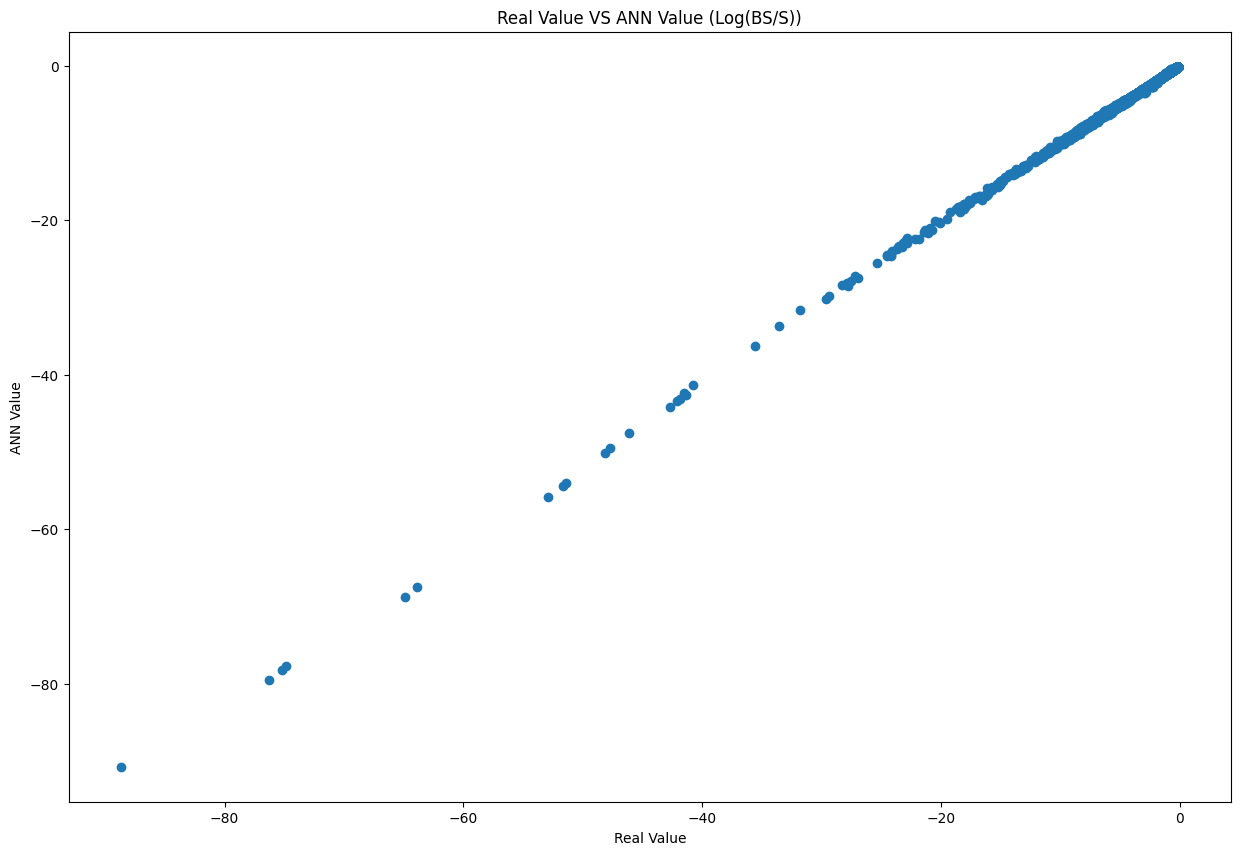

In [100]:

# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (20, 1), size=15)
plt.title('Real Value VS ANN Value (Log(BS/S))')
plt.show()

In [101]:
if np.any(y_pred == 0):
    print("There are zeros in y_pred")
else:
    print("There are no zeros in y_pred")

# Check if there are any zeros in y_test
if np.any(y_test == 0):
    print("There are zeros in y_test")
else:
    print("There are no zeros in y_test")

There are no zeros in y_pred
There are no zeros in y_test


In [102]:
data = np.column_stack((y_test, y_pred))
np.savetxt('y_test_y_pred.csv', data, delimiter=',', header='y_test,y_pred', comments='')

In [103]:
datafrac = pd.read_csv('y_test_y_pred.csv')

fractions statistics
Min: -0.49969762770089576
Max: 0.20757534366883035
Mean: -0.01883180136529298
Std: 0.02986516450951609


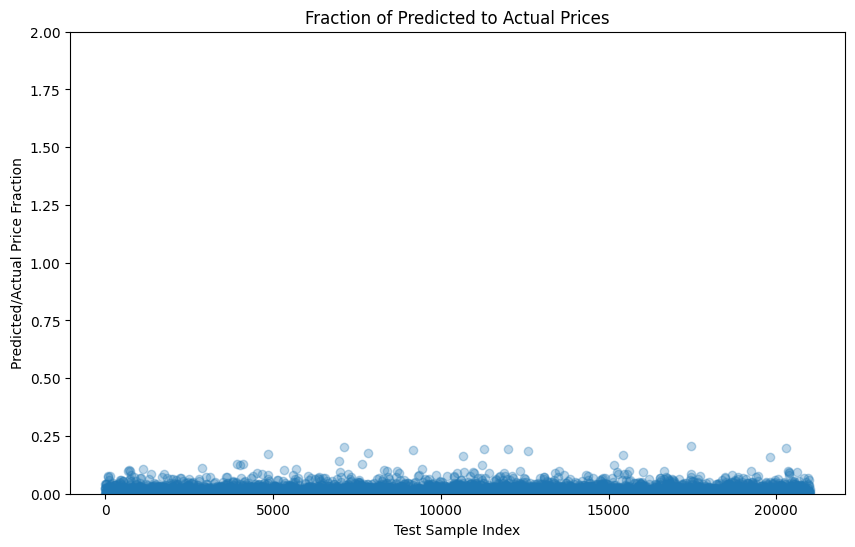

In [104]:
y_testf = datafrac['y_test'].values
y_predf = datafrac['y_pred'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price Fraction')
plt.title('Fraction of Predicted to Actual Prices')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

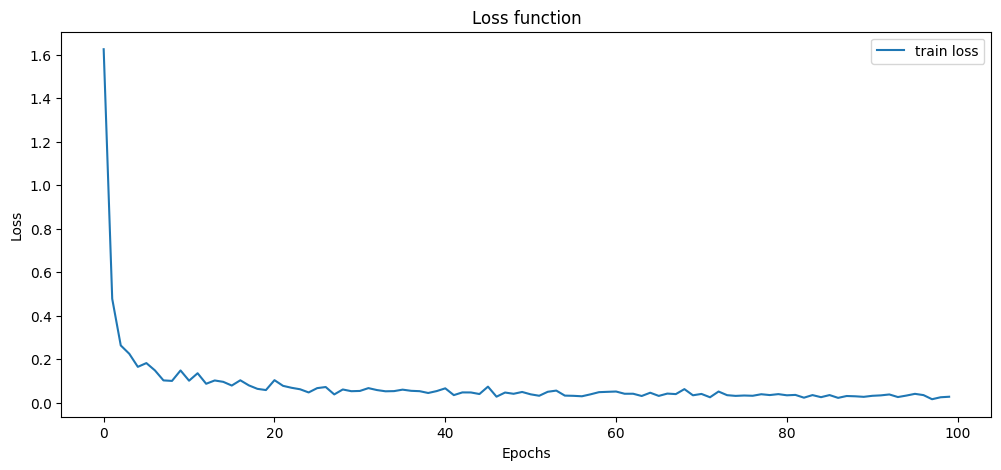

In [105]:
fig, ax = plt.subplots(figsize=(12, 5))
x_x = history.history["loss"]
ax.plot(history.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss function')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

In [113]:
history.history["loss"][-1]

0.02647903747856617